# Airbnb in Tibet and Xinjiang

This project was inspired by existing [reporting](https://www.theguardian.com/world/2021/dec/01/airbnb-allegedly-hosts-xinjiang-rentals-on-land-owned-by-sanctioned-group) on the presence of Airbnb in the occupied lands of Tibet and East Turkestan (governed by China as Xinjiang), [reports](https://www.wired.co.uk/article/airbnb-china-uyghur-muslim) that Tibetans and Uyghurs were facing discrimination from Airbnb hosts, and Airbnb's [sponsorship](https://www.forbes.com/sites/sofialottopersio/2019/11/18/airbnb-olympic-partnership-ahead-ipo/?sh=511a19fb57a1) of the controversial Beijing Winter Olympics.

I wanted to understand how many listings Airbnb has in historic Tibet (including parts of Tibet that are outside what China calls the Tibet Autonomous Region(TAR)) and East Turkestan/Xinjiang. I also wanted to see if there was any information contained with those listings that might help us to understand who owns these properties and about restrictions on who can rent them.

Airbnb doesn't have a publicly available API so I used a scraper hosted on [Apify](https://apify.com/dtrungtin/airbnb-scraper) to extract listings that mark their location as Tibet, Gansu, Qinghai, Sichuan, Yunnan and Xinjiang, to include all of historic Tibet and East Turkestan.

The listings were downloaded as JSON files for examination in this notebook. The formatting of some of the JSON files was slightly different as I was unfamiliar with the settings on the scraper and only had limited access so couldn't rerun the operations to standardise the output. The only impact of this was to make it slightly harder to join the datasets together.


In [3]:
#imports the relevant libraries

#these libraries handle the data formatting and arrangement
import pandas as pd
import numpy as np
import json
    
#these libraries are used to manage geographical data and visualise it
from shapely.geometry import Point, Polygon
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

#allows the use of regex
import re

### Importing and cleaning the Tibet data

I examined the files externally and identified the relevant and common columns. I then loaded the JSON files into one dataframe.

In [2]:
#this is a list of columns that are both relevant, and common to all the JSON files
columns = ['url', 'name', 'numberOfGuests', 'address', 'roomType', 'location',
       'reviews', 'pricing', 'id', 'isNewListing', 'listingRooms',
       'p3SummaryAddress', 'primaryHost', 
       'sectionedDescription', 'tierId', 'guestControls', 'priceDetails', 
       'additionalHosts', 'isHostedBySuperhost','descriptionLocale',
       'initialDescriptionAuthorType', 'city', 'country', 'countryCode',
       'hasHostGuidebook', 'hasLocalAttractions', 'neighborhoodCommunityTags',
       'state', 'paidGrowthRemarketingListingIds', 'hasCommercialHostInfo',
       'reviewDetailsInterface', 'reviewsOrder', 'hostQuote',
       'hostSignatureFont', 'nearbyAirportDistanceDescriptions',
       'propertyTypeInCity', 'renderTierId', 'isHotel', 'showReviewTag',
       'isRepresentativeInventory', 'localizedCity', 'highlights', 'sortedReviews',
       'documentDisplayPictures', 'sections', 'metadata', 'p3ImpressionId',
       'idStr',  'stars', 'hostGuidebook',
       'ugcTranslation', 'accessibilityModule']

In [3]:
#these are the names of the administrative regions that the data is pulled from (cities is a misnomer, these are regions). 
cities = ['gansu', 'qinghai', 'tibet', 'sichuan', 'yunnan']

In [4]:
#creates an empty dataframe with the relevant column names and an empty dictionary to initially hold all the data
listings_raw = pd.DataFrame(columns=columns)
listings_dict = {}

In [5]:
#iterates through the files putting them in a temporary dataframe that is added to a dictionary
for city in cities:
    #creates the string that will be the file name
    file_name = city + '.json'
    #sets the name of the dictionary key that will be used for each region
    key = city
    #reads the JSON file containing the data into a temporary datafram
    df = pd.read_json(file_name)
    #adds the dataframe as the item in a dictionary with the region name as the key
    listings_dict[key] = df
    #prints the name of the region and the number of records
    print(city,len(df))

gansu 2582
qinghai 756
tibet 317
sichuan 12940
yunnan 13433


In [6]:
#adds all of the entries in the dictionary to the empty dataframe, matching column names.
listings_raw = pd.concat(listings_dict)

### Finding which listings are in historic Tibet

There is no agreement about the exact borders of historic Tibet so I have used an approximation in the form of the Tibetan Plateau. For more information about the shape of historic Tibet see [here](https://freetibet.org/about/location)

I converted each location into a geographic point and filtered the list by those that are located within the shape of the Tibetan Plateau. 

In [7]:
#displays the unique values in the address column
listings_raw['address'].unique()

array(['Lanzhou, Gansu, China', 'Jiayuguan, Gansu, China',
       'Jiuquan, Gansu, China', 'Aba, Sichuan, China',
       'zhongwei, Ningxia, China', 'Baoji, Shaanxi, China',
       'Xining, Qinghai, China', 'Haixi, Qinghai, China',
       "Xi'an, Shaanxi, China", 'Alxa, Inner Mongolia, China',
       'Zhangye, Gansu, China', 'Yinchuan, Ningxia, China',
       'Tianshui, Gansu, China', 'Ankang, Shaanxi, China',
       'Beijing, China', 'Hainan, Qinghai, China',
       'Xianyang, Shaanxi, China', 'Hanzhong, Shaanxi, China',
       'Gannan, Gansu, China', 'Guangzhou, Guangdong, China',
       'Haixi Mengguzuzangzuzizhizhou, Qinghai Sheng, China', 'China',
       'Wuzhong, Ningxia, China', 'Haibei, Qinghai, China',
       'Haidong, Qinghai, China', 'Guyuan, Ningxia, China',
       'Linxia, Gansu, China', 'Baiyin, Gansu, China',
       'Alashan Meng, Neimenggu Zizhiqu, China', 'Chongqing, China',
       'Lanzhou Shi, Gansu Sheng, China', 'Changsha, Hunan, China',
       'Jinchang, Gansu, Ch

In [8]:
#splits the longitude and latitude data in the location column into separate columns in a new dataframe
listings_lnglat = pd.concat([listings_raw, listings_raw['location'].apply(pd.Series)], axis=1)

In [9]:
#displays the first few columns of the new dataframe
listings_lnglat.head()

url                    name  stars  \
gansu 0  https://www.airbnb.com/rooms/29755729    七里河地铁站附近5卧室房间，可入住11人    4.5   
      1  https://www.airbnb.com/rooms/35978133      舒适干净的家庭式公寓，欢迎您的入住！    NaN   
      2  https://www.airbnb.com/rooms/54119060    甘肃敦煌A·整栋整租团建会议度假轰趴多人    NaN   
      3  https://www.airbnb.com/rooms/26057614  火车站 步行200米 海天新都 欧式精品装修    NaN   
      4  https://www.airbnb.com/rooms/53913706   四川九寨沟D//别墅 聚会 度假 团建整租    NaN   

         numberOfGuests                  address                 roomType  \
gansu 0              11    Lanzhou, Gansu, China  Entire residential home   
      1               6  Jiayuguan, Gansu, China       Entire rental unit   
      2              16    Jiuquan, Gansu, China           Entire cottage   
      3               2    Lanzhou, Gansu, China       Entire rental unit   
      4              16      Aba, Sichuan, China           Entire cottage   

                                                  location reviews  \
gansu 0                    {'lat': 36.065, 'lng': 103.779}      []   
      1                 {'lat': 39.75833, 'lng': 98.26571}      []   
      2  {'lat': 40.10281359183165, 'lng': 94.670031791...      []   
      3                    {'lat': 36.038, 'lng': 103.847}      []   
      4                {'lat': 33.29189, 'lng': 103.86615}      []   

                                                   pricing  \
gansu 0  {'rate': {'amount': 13985, 'amount_formatted':...   
      1  {'rate': {'amount': 10069, 'amount_formatted':...   
      2  {'rate': {'amount': 2309, 'amount_formatted': ...   
      3  {'rate': {'amount': 1573, 'amount_formatted': ...   
      4  {'rate': {'amount': 1417, 'amount_formatted': ...   

                                          listingAmenities  ...  \
gansu 0  [{'description': '', 'id': 8, 'isPresent': Fal...  ...   
      1  [{'description': '', 'id': 45, 'isPresent': Tr...  ...   
      2  [{'description': '', 'id': 79, 'isPresent': Tr...  ...   
      3  [{'description': 'Space where guests can cook ...  ...   
      4  [{'description': '', 'id': 45, 'isPresent': Tr...  ...   

        accessibilityModule coverPhotoPrimary coverPhotoVertical  \
gansu 0                 NaN               NaN                NaN   
      1                 NaN               NaN                NaN   
      2                 NaN               NaN                NaN   
      3                 NaN               NaN                NaN   
      4                 NaN               NaN                NaN   

        educationModule hostInteraction amenitySection  houseRulesModule  \
gansu 0             NaN             NaN            NaN               NaN   
      1             NaN             NaN            NaN               NaN   
      2             NaN             NaN            NaN               NaN   
      3             NaN             NaN            NaN               NaN   
      4             NaN             NaN            NaN               NaN   

        ugcTranslation        lat         lng  
gansu 0            NaN  36.065000  103.779000  
      1            NaN  39.758330   98.265710  
      2            NaN  40.102814   94.670032  
      3            NaN  36.038000  103.847000  
      4            NaN  33.291890  103.866150  

[5 rows x 94 columns]

In [10]:
# creating a geometry column with a point marking the location of each listing
geometry = [Point(xy) for xy in zip(listings_lnglat['lng'], listings_lnglat['lat'])]

# Sets the oordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creates a Geographic dataframe
listings_gdf = gpd.GeoDataFrame(listings_lnglat, crs=crs, geometry=geometry)

C:\Users\werho\.conda\envs\data_vis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
# reads a new shapefile that outlines the Tibetan plateau which in this case is used as a proxy for
# the shape of historic Tibet.
tibet_plateau = gpd.read_file('shapefile/DBATP_Polygon.shp')

In [15]:
#Creates a boolean series that indicates whether a listing is within the Tibetan plateau (henceforth Tibet)or not.
in_tibet = listings_gdf['geometry'].within(tibet_plateau.loc[0]['geometry'])

In [17]:
#adds the new column on to the existing dataframe
listings_gdf = pd.concat([listings_gdf, in_tibet], axis=1)

In [18]:
#renames the column
listings_gdf.rename(columns={0:'in_tibet'}, inplace=True)

In [19]:
#displays the number of true and false values
listings_gdf['in_tibet'].value_counts()

False    27604
True      2424
Name: in_tibet, dtype: int64

In [21]:
#saves all the listings in Tibet to a new dataframe
listings_tibet_gdf = listings_gdf[listings_gdf['in_tibet']].reset_index()

In [22]:
#view an outline of the dataframe
listings_tibet_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 98 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   level_0                             2424 non-null   object  
 1   level_1                             2424 non-null   int64   
 2   url                                 2424 non-null   object  
 3   name                                2424 non-null   object  
 4   stars                               1194 non-null   float64 
 5   numberOfGuests                      2424 non-null   int64   
 6   address                             2424 non-null   object  
 7   roomType                            2424 non-null   object  
 8   location                            2424 non-null   object  
 9   reviews                             2424 non-null   object  
 10  pricing                             2424 non-null   object  
 11  listingAmenities      

In [23]:
#display the first few rows of the dataframe
listings_tibet_gdf.head()

,level_0,level_1,url,name,stars,numberOfGuests,address,roomType,location,reviews,...,coverPhotoVertical,educationModule,hostInteraction,amenitySection,houseRulesModule,ugcTranslation,lat,lng,geometry,in_tibet
0,gansu,4,https://www.airbnb.com/rooms/53913706,四川九寨沟D//别墅 聚会 度假 团建整租,NaN,16,"Aba, Sichuan, China",Entire cottage,"{'lat': 33.29189, 'lng': 103.86615}",[],...,NaN,NaN,NaN,NaN,NaN,NaN,33.29189,103.86615,POINT (103.86615 33.29189),True
1,gansu,9,https://www.airbnb.com/rooms/13918538,Kitty baby service apartment 小猫酒店式公寓,5.0,7,"Xining, Qinghai, China",Entire rental unit,"{'lat': 36.648, 'lng': 101.731}",[],...,NaN,NaN,NaN,NaN,NaN,NaN,36.64800,101.73100,POINT (101.73100 36.64800),True
2,gansu,10,https://www.airbnb.com/rooms/27358358,海湖新区 青庭公寓整套独户房布草一客一换，交通饮食便利,5.0,6,"Xining, Qinghai, China",Entire residential home,"{'lat': 36.642, 'lng': 101.737}",[],...,NaN,NaN,NaN,NaN,NaN,NaN,36.64200,101.73700,POINT (101.73700 36.64200),True
3,gansu,12,https://www.airbnb.com/rooms/53913574,四川九寨沟C//别墅 聚会 度假 团建 整栋整租,NaN,16,"Aba, Sichuan, China",Entire cottage,"{'lat': 33.27329, 'lng': 103.906}",[],...,NaN,NaN,NaN,NaN,NaN,NaN,33.27329,103.90600,POINT (103.90600 33.27329),True
4,gansu,13,https://www.airbnb.com/rooms/50013470,茶卡-悦慢小院-标准双床房,NaN,2,"Haixi, Qinghai, China",Private room in kezhan,"{'lat': 36.79542, 'lng': 99.08004}",[],...,NaN,NaN,NaN,NaN,NaN,NaN,36.79542,99.08004,POINT (99.08004 36.79542),True


In [24]:
#rename a column
listings_tibet_gdf.rename(columns={'level_0':'province'}, inplace=True)

In [25]:
#expand the host column
listings_tibet_gdf = pd.concat([listings_tibet_gdf, listings_tibet_gdf['primaryHost'].apply(pd.Series)], axis=1).drop(columns=['primaryHost'])

In [30]:
#Save the cleaned data to a csv file as a waypoint for the work
listings_tibet_gdf.to_csv('tibet_airbnb_listings.csv')

### Examining the Tibet data

The following section is a brief analysis of the data on Tibet. 

Overall there are the following numbers of listings in each province:

 Province | No. of Listings 
:---|:---
 Qinghai | 686 
 Gansu | 669 
 Sichuan | 518 
 TAR | 317 
 Yunnan | 234 


There are 801 listings in the Qinghai capital of Xining but many of these are listed as being in Gansu province. Xining was in Gansu until borders were changed in 1928.


In [22]:
#reopen the spreadsheet as a geodataframe
listings_tibet_gdf = pd.read_csv('tibet_airbnb_listings.csv', low_memory=False)
listings_tibet_gdf = listings_tibet_gdf[listings_tibet_gdf['province'].isin(['qinghai', 'gansu', 'sichuan', 'tibet', 'yunnan'])]

In [23]:
#count the number of listings withing Tibet in each administrative province 
listings_tibet_gdf['province'].value_counts()

qinghai    686
gansu      669
sichuan    518
tibet      317
yunnan     234
Name: province, dtype: int64

In [24]:
#count the number of listings in Xining
len(listings_tibet_gdf[listings_tibet_gdf['address'].str.contains('Xining')])

801

In [25]:
#examining which province the Xining listings have been listed in.
xining_df = listings_tibet_gdf[listings_tibet_gdf['address'].str.contains('Xining')]
xining_df['province'].value_counts()

qinghai    484
gansu      317
Name: province, dtype: int64

In [36]:
#creates and displays a new list of the 'addresses' of any listings marked as in the Qinghai region 
address_series = np.sort(listings_tibet_gdf['address'][listings_tibet_gdf['province'] == 'qinghai'].unique())
print(address_series)

['Aba, Sichuan, China' 'Gannan, Gansu, China' 'Garze, Sichuan, China'
 'Haibei, Qinghai, China' 'Haidong Shi, Qinghai Sheng, China'
 'Haidong, Qinghai, China'
 'Hainan Tibetan Autonomous Prefecture, China, Qinghai, China'
 'Hainan, Qinghai, China'
 'Haixi Mengguzuzangzuzizhizhou, Qinghai Sheng, China'
 'Haixi, Qinghai, China' 'Huangnan, Qinghai, China'
 'Xining Shi, Qinghai Sheng, China' 'Xining, Qinghai Sheng, China'
 'Xining, Qinghai, China'
 'haixi_mongol_and_tibetan_autonomous_prefecture, Qinghai, China']


In [37]:
#creates a list of the columns in the dataframe and displays the first 100.
columns = listings_tibet_gdf.columns
columns[:100]

Index(['Unnamed: 0', 'province', 'level_1', 'url', 'name', 'stars',
       'numberOfGuests', 'address', 'roomType', 'location', 'reviews',
       'pricing', 'listingAmenities', 'rootAmenitySections',
       'seeAllAmenitySections', 'bathroomLabel', 'bedLabel', 'bedroomLabel',
       'hasHouseRules', 'id', 'isNewListing', 'listingRooms',
       'p3SummaryAddress', 'photos', 'roomTypeCategory',
       'sectionedDescription', 'tierId', 'guestControls', 'hasSpecialOffer',
       'maxNights', 'minNights', 'priceDetails', 'hasWeWorkLocation',
       'isBusinessTravelReady', 'additionalHosts', 'isHostedBySuperhost',
       'hometourRooms', 'hometourSections', 'descriptionLocale',
       'initialDescriptionAuthorType', 'localizedCheckInTimeWindow',
       'localizedCheckOutTime', 'city', 'country', 'countryCode',
       'hasHostGuidebook', 'hasLocalAttractions', 'neighborhoodCommunityTags',
       'state', 'paidGrowthRemarketingListingIds', 'hasCommercialHostInfo',
       'reviewDetailsInterfa

### Listings in Xinjiang

Once I'd looked at the listings in Tibet, I turned to the slightly more straightforward area of East Turkestan. Although the independence and name of the area is in dispute the names Xinjiang Uyghur Autonomous Region (XUAR) and East Turkestan refer to the same area, unlike Tibet which refers to a larger and less defined area than the TAR.

At first I did a basic clean up of the data and checked to make sure that all those properties listed as being in XUAR actually were.

In [7]:
#reads in the file containing the listings
xinjiang_listings = pd.read_csv('xinjiang.csv', low_memory=False)

In [8]:
#excludes listings that don't mention Xinjiang
xinjiang_listings = xinjiang_listings[xinjiang_listings['address'].str.contains('Xinjiang')]

In [9]:
#shows the unique locations
xinjiang_listings['address'].unique()

array(['Kashgar, Xinjiang, China', 'Kashgar Prefecture, Xinjiang, China',
       'Kizilsu, Xinjiang, China', 'Turpan, Xinjiang, China',
       'Altay, Xinjiang, China', 'Ili, Xinjiang, China',
       'Karamay, Xinjiang, China', 'Wujiaqu, Xinjiang, China',
       'Urumqi, Xinjiang, China', 'Bayingol, Xinjiang, China',
       'city.Altay Prefecture, China, Xinjiang, China',
       'Changji, Xinjiang, China',
       'Wulumuqi Shi, Xinjiang Weiwuerzizhiqu, China',
       'Shihezi, Xinjiang, China', 'Kumul, Xinjiang, China',
       'Aksu, Xinjiang, China', 'Bortala, Xinjiang, China',
       'Qoqek, Xinjiang, China'], dtype=object)

I wanted to check if there was any mention of Uyghurs in the house rules of the listings, which could be an indication of discrimination.

In [26]:
#searches for mentions of Uyghurs in Xinjiang listings
uyghur_mentions = xinjiang_listings[xinjiang_listings['sectionedDescription/houseRules'].str.contains('uyghur|uighur|uygur|维吾尔|維吾爾', na=False)]

In [27]:
#shows that just one of the listings mention Uyghurs
uyghur_mentions.shape

(1, 2001)

In [33]:
#prints the text of the listing
print(uyghur_mentions.loc[10,'sectionedDescription/houseRules'])

本房源禁止宠物入内，由于工区众多，又是按维吾尔人传统别墅设计，软装多用地毯壁毯，休闲亭子间两处，设有地毯和坐垫，需脱鞋入内。院内工区摆放本地土陶等艺术品，请勿触摸。


The above text, the only reference to Uyghurs in the house rules of the listings in XUAR, translates as:
>This listing does not allow pets to enter. Due to the large number of working areas, it is designed according to the traditional Uyghur villas, with soft furnishings and multi-purpose carpets and tapestries. There are two leisure pavilions with carpets and cushions. You need to take off your shoes to enter. Local earthenware and other artworks are placed in the work area of the courtyard, please do not touch.

Suggesting that, in the house rules at least, there is not explicit discrimination against Uyghurs.

In [34]:
#reads in the shape file of all of the provinces. 
#The file was obtained from the China Data Institute at Harvard University - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBJ3BX
provinces = gpd.read_file('chn_admbnda_adm1_ocha_2020.shp')

In [35]:
#displayes the file
provinces

,ADM1_EN,ADM1_ZH,ADM1_PCODE,ADM0_EN,ADM0_ZH,ADM0_PCODE,geometry
0,Shaanxi Province,陕西省,CN061,China,中国,CN,"POLYGON ((109.43453 33.15591, 109.43417 33.153..."
1,Shanghai Municipality,上海市,CN031,China,中国,CN,"MULTIPOLYGON (((121.24731 31.73074, 121.24566 ..."
2,Chongqing Municipality,重庆市,CN050,China,中国,CN,"POLYGON ((109.54600 31.72161, 109.56352 31.718..."
3,Zhejiang Province,浙江省,CN033,China,中国,CN,"MULTIPOLYGON (((120.46805 27.16108, 120.46718 ..."
4,Jiangxi Province,江西省,CN036,China,中国,CN,"POLYGON ((116.53885 26.56975, 116.55643 26.540..."
5,Yunnan Province,云南省,CN053,China,中国,CN,"POLYGON ((105.51205 23.20864, 105.49400 23.230..."
6,Shandong Province,山东省,CN037,China,中国,CN,"MULTIPOLYGON (((120.27662 36.00127, 120.27536 ..."
7,Liaoning Province,辽宁省,CN021,China,中国,CN,"MULTIPOLYGON (((121.42978 39.50441, 121.42695 ..."
8,Tibet Autonomous Region,西藏自治区,CN054,China,中国,CN,"POLYGON ((90.12055 28.17220, 90.11962 28.17022..."
9,Gansu province,甘肃省,CN062,China,中国,CN,"POLYGON ((106.50714 34.22042, 106.55785 34.190..."


In [12]:
#creates a geometry column 
geometry = [Point(xy) for xy in zip(xinjiang_listings['location/lng'], xinjiang_listings['location/lat'])]

#Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

#creates a Geographic data frame 
xinjiang_gdf = gpd.GeoDataFrame(xinjiang_listings, crs=crs, geometry=geometry)

C:\Users\werho\.conda\envs\data_vis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
#selects the xinjiang outline
xinjiang_geo = provinces.loc[20,'geometry']

In [12]:
#creates a boolean series indicating whether a listing is within xinjiang
in_xinjiang = xinjiang_gdf['geometry'].within(xinjiang_geo)
in_xinjiang = pd.Series(in_xinjiang)

In [14]:
#combines the boolean column with the original dataframe
xinjiang_listings = pd.concat([xinjiang_listings, in_xinjiang], axis=1)

In [15]:
#displays the columns
xinjiang_listings.columns

Index([           'accessibilityModule/amenities/0/description',
                           'accessibilityModule/amenities/0/id',
                    'accessibilityModule/amenities/0/isPresent',
                         'accessibilityModule/amenities/0/name',
                         'accessibilityModule/rootHighlights/0',
            'accessibilityModule/seeAllSections/0/amenityIds/0',
                      'accessibilityModule/seeAllSections/0/id',
        'accessibilityModule/seeAllSections/0/photos/0/caption',
             'accessibilityModule/seeAllSections/0/photos/0/id',
       'accessibilityModule/seeAllSections/0/photos/0/largeUrl',
       ...
                                  'seeAllAmenitySections/12/id',
                            'seeAllAmenitySections/12/subtitle',
                               'seeAllAmenitySections/12/title',
                                                'showReviewTag',
                                                        'stars',
              

In [16]:
#removes listings that aren't in Xinjiang
xinjiang_listings = xinjiang_listings[xinjiang_listings[0] == True]

In [17]:
#shows the shape of the dataframe
xinjiang_listings.shape

(520, 2002)

In [18]:
#displays unique addresses 
xinjiang_listings['address'].unique()

array(['Kashgar, Xinjiang, China', 'Kashgar Prefecture, Xinjiang, China',
       'Kizilsu, Xinjiang, China', 'Turpan, Xinjiang, China',
       'Altay, Xinjiang, China', 'Ili, Xinjiang, China',
       'Karamay, Xinjiang, China', 'Wujiaqu, Xinjiang, China',
       'Urumqi, Xinjiang, China', 'Bayingol, Xinjiang, China',
       'city.Altay Prefecture, China, Xinjiang, China',
       'Changji, Xinjiang, China',
       'Wulumuqi Shi, Xinjiang Weiwuerzizhiqu, China',
       'Shihezi, Xinjiang, China', 'Kumul, Xinjiang, China',
       'Aksu, Xinjiang, China', 'Bortala, Xinjiang, China',
       'Qoqek, Xinjiang, China'], dtype=object)

In [19]:
#saves the dataframe to a csv
xinjiang_listings.to_csv('xinjiang_airbnb_listings.csv')

### Mapping the listings

The following section maps the listings found in Tibet and East Turkestan.

The first section standardises the columns in the Tibet and East Turkestan listings dataframes and combines them into one dataframe for mapping.

In [20]:
#reads in the latest version of the Tibet listings
tibet_df = pd.read_csv('tibet_airbnb_listings.csv', low_memory=False)

In [21]:
#rereads the Xinjiang listings
xinjiang_df = pd.read_csv('xinjiang_airbnb_listings_map.csv', low_memory=False)

In [22]:
#displays the first 50 columns of the Tibet dataframe
tibet_df.columns[:50]

Index(['Unnamed: 0', 'province', 'level_1', 'url', 'name', 'stars',
       'numberOfGuests', 'address', 'roomType', 'location', 'reviews',
       'pricing', 'listingAmenities', 'rootAmenitySections',
       'seeAllAmenitySections', 'bathroomLabel', 'bedLabel', 'bedroomLabel',
       'hasHouseRules', 'id', 'isNewListing', 'listingRooms',
       'p3SummaryAddress', 'photos', 'roomTypeCategory',
       'sectionedDescription', 'tierId', 'guestControls', 'hasSpecialOffer',
       'maxNights', 'minNights', 'priceDetails', 'hasWeWorkLocation',
       'isBusinessTravelReady', 'additionalHosts', 'isHostedBySuperhost',
       'hometourRooms', 'hometourSections', 'descriptionLocale',
       'initialDescriptionAuthorType', 'localizedCheckInTimeWindow',
       'localizedCheckOutTime', 'city', 'country', 'countryCode',
       'hasHostGuidebook', 'hasLocalAttractions', 'neighborhoodCommunityTags',
       'state', 'paidGrowthRemarketingListingIds'],
      dtype='object')

In [23]:
#displays the xinjiang columns
xinjiang_df.columns

Index(['Unnamed: 0', 'address', 'bedLabel', 'city', 'photo', 'price',
       'roomType', 'stars', 'state', 'url', 'geometry', 'lat', 'lng'],
      dtype='object')

In [24]:
#extracts latitude and longitude from the Tibet dataframe
longlat = tibet_df['location'].str.extract(r"'lat': (?P<lat>\d+\.\d+).+'lng': (?P<long>\d+\.\d+)")

In [25]:
#adds the new columns back onto the dataframe
tibet_df = pd.concat([tibet_df, longlat['long'], longlat['lat']], axis=1)

In [26]:
#displays a snapshot of the dataframe
tibet_df

,Unnamed: 0,province,level_1,url,name,stars,numberOfGuests,address,roomType,location,...,isSuperhost,languages,memberSinceFullStr,name.1,pictureLargeUrl,pictureUrl,responseRateWithoutNa,responseTimeWithoutNa,long,lat
0,0,gansu,4,https://www.airbnb.com/rooms/53913706,四川九寨沟D//别墅 聚会 度假 团建整租,NaN,16,"Aba, Sichuan, China",Entire cottage,"{'lat': 33.29189, 'lng': 103.86615}",...,False,[],Joined in November 2021,Yinliting,https://a0.muscache.com/im/pictures/user/318c1...,https://a0.muscache.com/im/pictures/user/318c1...,100%,within an hour,103.86615,33.29189
1,1,gansu,9,https://www.airbnb.com/rooms/13918538,Kitty baby service apartment 小猫酒店式公寓,5.0,7,"Xining, Qinghai, China",Entire rental unit,"{'lat': 36.648, 'lng': 101.731}",...,True,"['中文 (简体)', 'English']",Joined in July 2016,Jane,https://a0.muscache.com/im/pictures/user/a1ad6...,https://a0.muscache.com/im/pictures/user/a1ad6...,NaN,NaN,101.731,36.648
2,2,gansu,10,https://www.airbnb.com/rooms/27358358,海湖新区 青庭公寓整套独户房布草一客一换，交通饮食便利,5.0,6,"Xining, Qinghai, China",Entire residential home,"{'lat': 36.642, 'lng': 101.737}",...,False,[],Joined in July 2018,凤明,https://a0.muscache.com/im/pictures/user/4da07...,https://a0.muscache.com/im/pictures/user/4da07...,NaN,NaN,101.737,36.642
3,3,gansu,12,https://www.airbnb.com/rooms/53913574,四川九寨沟C//别墅 聚会 度假 团建 整栋整租,NaN,16,"Aba, Sichuan, China",Entire cottage,"{'lat': 33.27329, 'lng': 103.906}",...,False,[],Joined in November 2021,Yinliting,https://a0.muscache.com/im/pictures/user/318c1...,https://a0.muscache.com/im/pictures/user/318c1...,100%,within an hour,103.906,33.27329
4,4,gansu,13,https://www.airbnb.com/rooms/50013470,茶卡-悦慢小院-标准双床房,NaN,2,"Haixi, Qinghai, China",Private room in kezhan,"{'lat': 36.79542, 'lng': 99.08004}",...,False,['中文 (简体)'],Joined in May 2021,永军,https://a0.muscache.com/im/pictures/user/afdbc...,https://a0.muscache.com/im/pictures/user/afdbc...,100%,within a few hours,99.08004,36.79542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,2419,yunnan,13358,https://www.airbnb.com/rooms/47042143,【凡舍客栈】藏式观景大床房（大落地窗/大庭院/地暖/免费停车/位于独克宗古城）,NaN,2,"Deqen, Yunnan, China",Private room in kezhan,"{'lat': 27.808, 'lng': 99.707}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.707,27.808
2420,2420,yunnan,13371,https://www.airbnb.com/rooms/47042143,【凡舍客栈】藏式观景大床房（大落地窗/大庭院/地暖/免费停车/位于独克宗古城）,NaN,2,"Deqen, Yunnan, China",Private room in kezhan,"{'lat': 27.808, 'lng': 99.707}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.707,27.808
2421,2421,yunnan,13401,https://www.airbnb.com/rooms/38554278,香格里拉古城星空阁楼蜜月房（两晚免费接机+双人浴缸+地暖）,5.0,2,"Deqen, Yunnan, China",Private room in kezhan,"{'lat': 27.811, 'lng': 99.705}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.705,27.811
2422,2422,yunnan,13408,https://www.airbnb.com/rooms/38554278,香格里拉古城星空阁楼蜜月房（两晚免费接机+双人浴缸+地暖）,5.0,2,"Deqen, Yunnan, China",Private room in kezhan,"{'lat': 27.811, 'lng': 99.705}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.705,27.811


In [27]:
#extracts links to the photos of the listings and their price
#this cell was for use in a version of the map that didn't work
photo = tibet_df['photos'].str.extract(r".'large': '(?P<photo>https.+?large)")
tibet_df = pd.concat([tibet_df, photo['photo']], axis=1)

price = tibet_df['location'].str.extract(r".'value': '(?P<price>\$\d+)")
tibet_df = pd.concat([tibet_df, price['price']], axis=1)

In [29]:
#pulls a subset of the Tibet dataframe to match the Xinjiang dataframe
tibet_df_edit = tibet_df[['address', 'bedLabel', 'city', 'photo', 'price','roomType', 'stars', 'state', 'url', 'geometry', 'lat', 'long']]

In [30]:
#checks the columns match
print(xinjiang_df.columns)
print(tibet_df_edit.columns)

Index(['Unnamed: 0', 'address', 'bedLabel', 'city', 'photo', 'price',
       'roomType', 'stars', 'state', 'url', 'geometry', 'lat', 'lng'],
      dtype='object')
Index(['address', 'bedLabel', 'city', 'photo', 'price', 'roomType', 'stars',
       'state', 'url', 'geometry', 'lat', 'lat', 'long'],
      dtype='object')


In [31]:
#renames a column to match
xinjiang_df.rename(columns={'lng':'long'}, inplace=True)

In [32]:
#removes duplicate columns
tibet_df_edit = tibet_df_edit.loc[:,~tibet_df_edit.columns.duplicated()]

In [33]:
#joins the two listings
full_listings = pd.concat([xinjiang_df,tibet_df_edit], axis=0)

In [35]:
#saves to a csv file as a waypoint
full_listings.to_csv('full_airbnb_listings.csv')

The following code puts the combined data onto a map plot.

In [17]:
#reads the file from csv
listings = pd.read_csv('full_airbnb_listings.csv')

In [18]:
#converts the latitude and longitude to numeric values
listings['lat'] = pd.to_numeric(listings['lat'], errors='coerce')
listings['long'] = pd.to_numeric(listings['long'], errors='coerce')

In [19]:
#converts the dataframe to a geodataframe
listings_gpd = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings['long'], listings['lat']), crs={'init': 'epsg:4326'})

C:\Users\werho\.conda\envs\data_vis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [40]:
#counts the number in each region
#(there are some error values here that will be cleaned up later)
listings['state'].value_counts()

Qinghai                    550
Sichuan                    441
Xinjiang                   382
Tibet                      186
Yunnan                     179
Xizang                     124
Gansu                       13
Qinghai Sheng               11
Xinjiang Weiwuerzizhiqu      2
Name: state, dtype: int64

In [13]:
#prints an alphabetical list of the province shapes
provinces.sort_values(by='ADM1_EN')

,ADM1_EN,ADM1_ZH,ADM1_PCODE,ADM0_EN,ADM0_ZH,ADM0_PCODE,geometry
16,Anhui Province,安徽省,CN034,China,中国,CN,"POLYGON ((118.84470 30.14634, 118.85715 30.116..."
12,Beijing Municipality,北京市,CN011,China,中国,CN,"POLYGON ((117.31471 40.18092, 117.31990 40.173..."
2,Chongqing Municipality,重庆市,CN050,China,中国,CN,"POLYGON ((109.54600 31.72161, 109.56352 31.718..."
30,Fujian Province,福建省,CN035,China,中国,CN,"MULTIPOLYGON (((118.05828 24.35708, 118.05729 ..."
9,Gansu province,甘肃省,CN062,China,中国,CN,"POLYGON ((106.50714 34.22042, 106.55785 34.190..."
29,Guangdong Province,广东省,CN044,China,中国,CN,"MULTIPOLYGON (((110.60024 21.18997, 110.56774 ..."
24,Guangxi Zhuang Autonomous Region,广西壮族自治区,CN045,China,中国,CN,"MULTIPOLYGON (((108.16305 21.52938, 108.12871 ..."
17,Guizhou Province,贵州省,CN052,China,中国,CN,"POLYGON ((106.59392 25.10086, 106.53206 25.088..."
33,Hainan Province,海南省,CN046,China,中国,CN,"MULTIPOLYGON (((109.76458 18.31635, 109.76458 ..."
27,Hebei Province,河北省,CN013,China,中国,CN,"MULTIPOLYGON (((118.84565 39.10664, 118.84137 ..."


In [49]:
#picks the relevant provinces
provinces = provinces.loc[[5,8,9,11,20,23]]

In [37]:
#creates a point in the middle of each polygon
#was created by looking at a display of the shapes but this cell is ulimately unused
middles = pd.DataFrame(data={'province' : ['Yunnan', 'TAR', 'Gansu', 'Qinghai', 'XUAR', 'Sichuan'],
                             'x' : [99, 86, 94, 92, 84, 104], 
                             'y' : [25, 33, 40, 34, 39, 25]})

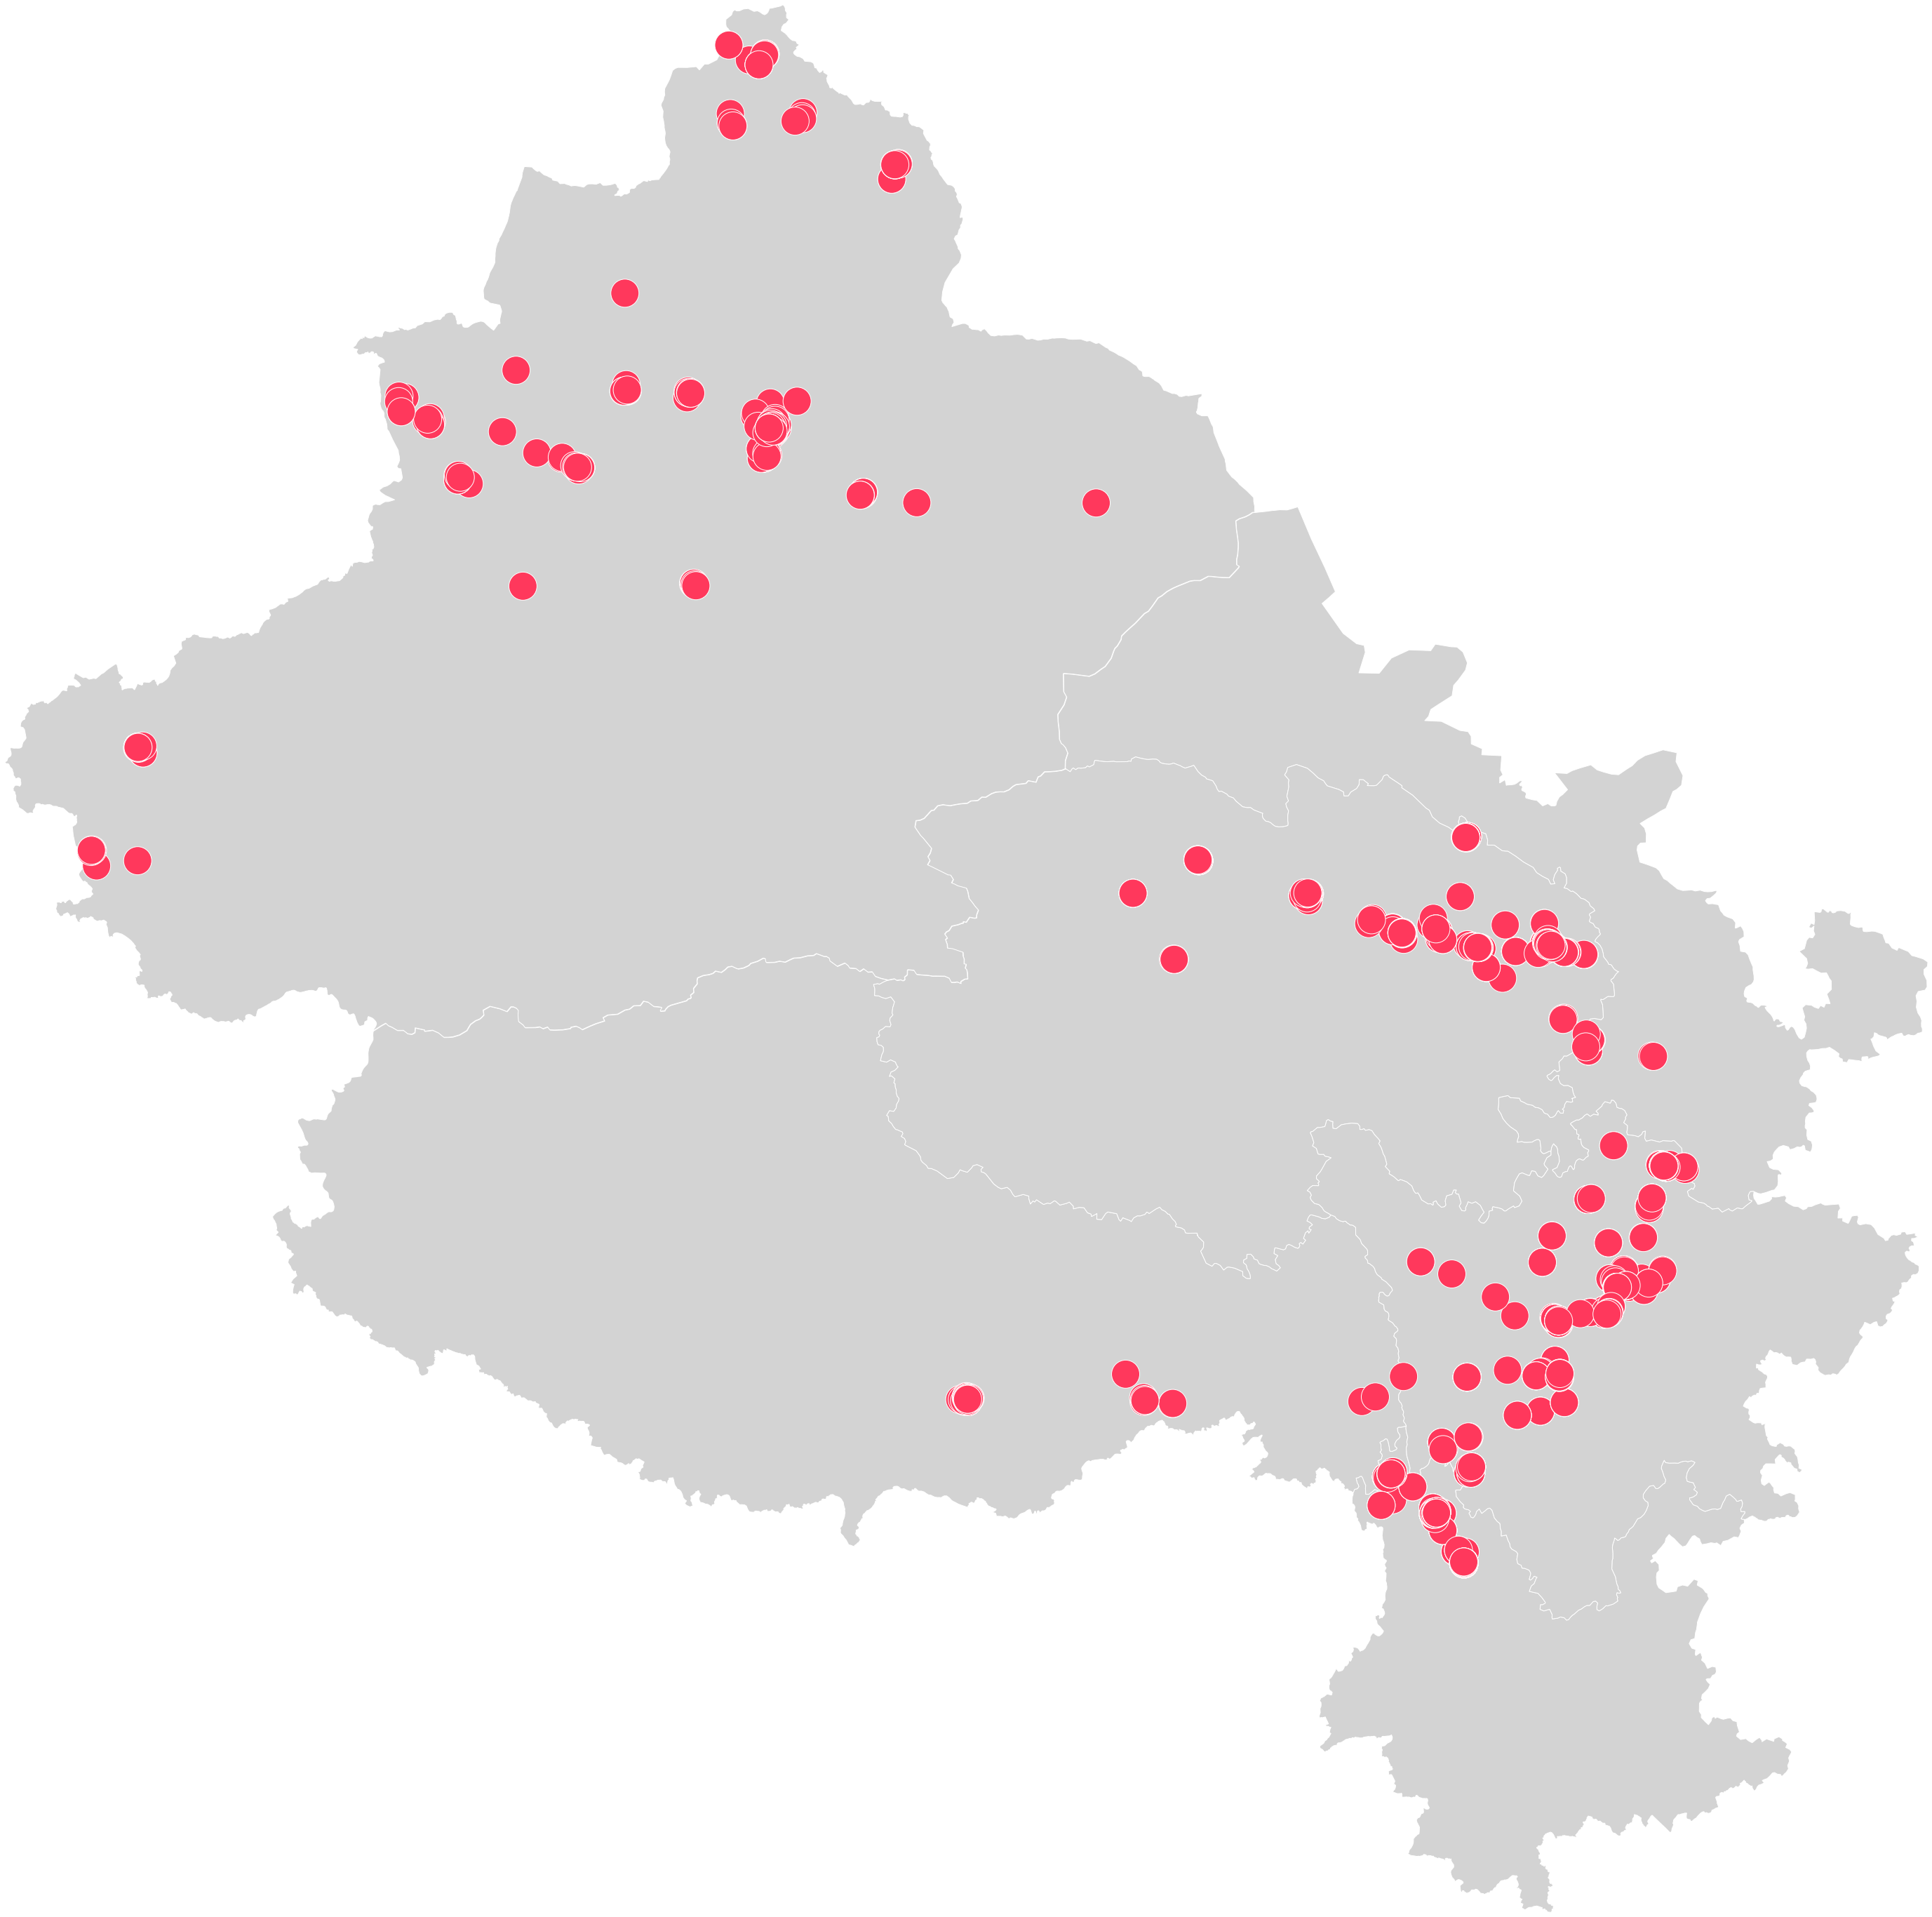

In [20]:
#Displays a map of points of each of the listings in the relevant regions
bounds=provinces.total_bounds
ax = gplt.polyplot(provinces,
                  gplt.crs.Mercator(),
                  figsize=(50,50),
                  edgecolor='white',
                  facecolor='lightgray',)
pointplot_kwargs={'marker':'o', 'color':'#FF385C', 'edgecolor':'white'}
# The commented code places the markers at the bottom of the page, I can't work out why or how to fix it.
# for idx, row in middles.iterrows():
#     ax.text(float(row[1]), float(row[2]), s=row[0])
gplt.pointplot(listings_gpd,
               extent=bounds,
                ax=ax,
                s=40,
                **pointplot_kwargs)
plt.savefig('all_locations.png')

The above map shows a concentration of listings in XUAR around Urumqi. 

In TAR they are focused around Lhasa, and elsewhere in Tibet in the more populous areas at the edge of the Tibetan Plateau. 

Bear in mind that there are listings in some of the provinces that are outside of historic Tibet and therefore not shown on this map.

In [45]:
#shows a list of the unique addresses including some data errors
listings['address'].unique()

array(['Kashgar, Xinjiang, China', 'Kashgar Prefecture, Xinjiang, China',
       'Kizilsu, Xinjiang, China', nan, 'Turpan, Xinjiang, China',
       'Altay, Xinjiang, China', 'Ili, Xinjiang, China',
       'Karamay, Xinjiang, China', 'Wujiaqu, Xinjiang, China',
       'Urumqi, Xinjiang, China', 'Bayingol, Xinjiang, China',
       'city.Altay Prefecture, China, Xinjiang, China',
       'Changji, Xinjiang, China',
       'Wulumuqi Shi, Xinjiang Weiwuerzizhiqu, China',
       'Shihezi, Xinjiang, China', 'Kumul, Xinjiang, China',
       'Aksu, Xinjiang, China', 'Bortala, Xinjiang, China',
       'Aba, Sichuan, China', 'Xining, Qinghai, China',
       'Haixi, Qinghai, China', 'Hainan, Qinghai, China',
       'Gannan, Gansu, China',
       'Haixi Mengguzuzangzuzizhizhou, Qinghai Sheng, China',
       'Haibei, Qinghai, China', 'Haidong, Qinghai, China',
       'Huangnan, Qinghai, China', 'Xining Shi, Qinghai Sheng, China',
       'Hainan Tibetan Autonomous Prefecture, China, Qinghai, China',
 

The next section groups the listings together by location to show where the concentrations are.

In [46]:
#filters the listings to remove the rows with error data
listings = listings[listings['address'].isin(['Kashgar, Xinjiang, China', 'Kashgar Prefecture, Xinjiang, China',
       'Kizilsu, Xinjiang, China', 'Turpan, Xinjiang, China',
       'Altay, Xinjiang, China', 'Ili, Xinjiang, China',
       'Karamay, Xinjiang, China', 'Wujiaqu, Xinjiang, China',
       'Urumqi, Xinjiang, China', 'Bayingol, Xinjiang, China',
       'city.Altay Prefecture, China, Xinjiang, China',
       'Changji, Xinjiang, China',
       'Wulumuqi Shi, Xinjiang Weiwuerzizhiqu, China',
       'Shihezi, Xinjiang, China', 'Kumul, Xinjiang, China',
       'Aksu, Xinjiang, China', 'Bortala, Xinjiang, China',
       'Aba, Sichuan, China', 'Xining, Qinghai, China',
       'Haixi, Qinghai, China', 'Hainan, Qinghai, China',
       'Gannan, Gansu, China',
       'Haixi Mengguzuzangzuzizhizhou, Qinghai Sheng, China', 'Haibei, Qinghai, China',
       'Haidong, Qinghai, China',
       'Huangnan, Qinghai, China', 'Xining Shi, Qinghai Sheng, China',
       'Hainan Tibetan Autonomous Prefecture, China, Qinghai, China',
       'Haidong Shi, Qinghai Sheng, China',
       'Xining, Qinghai Sheng, China',
       'Huangnan Tibetan Autonomous Prefecture, Qinghai, China',
       'Haibei Zangzuzizhizhou, Qinghai Sheng, China',
       'haixi_mongol_and_tibetan_autonomous_prefecture, Qinghai, China',
       'Garze, Sichuan, China', 'Lhasa, Xizang, China',
       'Lhasa, Tibet, China',
       'Nyingchi, Xizang, China',
       'Deqen, Yunnan, China', 'Qamdo, Tibet, China',
       'Lijiang, Yunnan, China',
       'Nujiang, Yunnan, China',
       'Shangri-La, Yunnan, China'])]

In [204]:
#shows a clean list of unique addresses
listings['address'].value_counts()

Xining, Qinghai, China                                            797
Deqen, Yunnan, China                                              296
Aba, Sichuan, China                                               259
Garze, Sichuan, China                                             219
Haixi, Qinghai, China                                             210
Lhasa, Tibet, China                                               180
Urumqi, Xinjiang, China                                           141
Lhasa, Xizang, China                                              118
Lijiang, Yunnan, China                                             88
Hainan, Qinghai, China                                             81
Kashgar, Xinjiang, China                                           78
Haidong, Qinghai, China                                            56
Ili, Xinjiang, China                                               54
Altay, Xinjiang, China                                             47
Haibei, Qinghai, Chi

In [39]:
#creates a copy of the listings dataframe
listings_by_city = listings.copy()

In [40]:
#cleans the list to standardise region names
listings_by_city.replace(to_replace={'Haixi Mengguzuzangzuzizhizhou, Qinghai Sheng, China' : 'Haixi, Qinghai, China',
                                     'Hainan Tibetan Autonomous Prefecture, China, Qinghai, China' : 'Hainan Tibetan Autonomous Prefecture, Qinghai, China',
                                     'city.Altay Prefecture, China, Xinjiang, China' : 'Altay Prefecture, Xinjiang, China',
                                     'Haidong Shi, Qinghai Sheng, China' : 'Haidong Shi, Qinghai, China',
                                     'Wulumuqi Shi, Xinjiang Weiwuerzizhiqu, China' : 'Urumqi, Xinjiang, China',
                                     'Xining Shi, Qinghai Sheng, China' : 'Xining, Qinghai, China',
                                     'Xining, Qinghai Sheng, China' : 'Xining, Qinghai, China',
                                     'Haibei Zangzuzizhizhou, Qinghai Sheng, China' : 'Haibei, Qinghai, China',
                                     'Kashgar Prefecture, Xinjiang, China' : 'Kashgar, Xinjiang, China',
                                     'haixi_mongol_and_tibetan_autonomous_prefecture, Qinghai, China' : 'Haixi, Qinghai, China',
                                     'Lhasa, Xizang, China' : 'Lhasa, Tibet, China'},
                         inplace=True)
                                     

In [41]:
#shows the standardised counts of values by region
listings_by_city['address'].value_counts()

Xining, Qinghai, China                                    801
Lhasa, Tibet, China                                       298
Deqen, Yunnan, China                                      296
Aba, Sichuan, China                                       259
Haixi, Qinghai, China                                     222
Garze, Sichuan, China                                     219
Urumqi, Xinjiang, China                                   143
Lijiang, Yunnan, China                                     88
Hainan, Qinghai, China                                     81
Kashgar, Xinjiang, China                                   79
Haidong, Qinghai, China                                    56
Ili, Xinjiang, China                                       54
Altay, Xinjiang, China                                     47
Haibei, Qinghai, China                                     45
Turpan, Xinjiang, China                                    26
Gannan, Gansu, China                                       22
Karamay,

In [42]:
#removes the 'China' text from the names
listings_by_city['address'] = listings_by_city['address'].str.replace(', China',"")

In [43]:
#creates a new dataframe with the count of listings by city
listing_counts_by_city = listings_by_city['address'].value_counts().rename_axis('address').reset_index(name='counts')

In [44]:
#drops the duplicates from the listings
listing_no_duplicates = listings_by_city.drop_duplicates('address')

In [45]:
#sorts both new dataframes alphabetically
listing_no_duplicates = listing_no_duplicates.sort_values('address').reset_index()
listing_counts_by_city = listing_counts_by_city.sort_values('address').reset_index()

In [46]:
#combines the two new dataframes
listing_counts_by_city = pd.concat([listing_counts_by_city, listing_no_duplicates['geometry']], axis=1).drop('index', axis=1)

In [47]:
#converts the new dataframe to a geodataframe
listing_counts_by_city = gpd.GeoDataFrame(listing_counts_by_city, geometry='geometry')

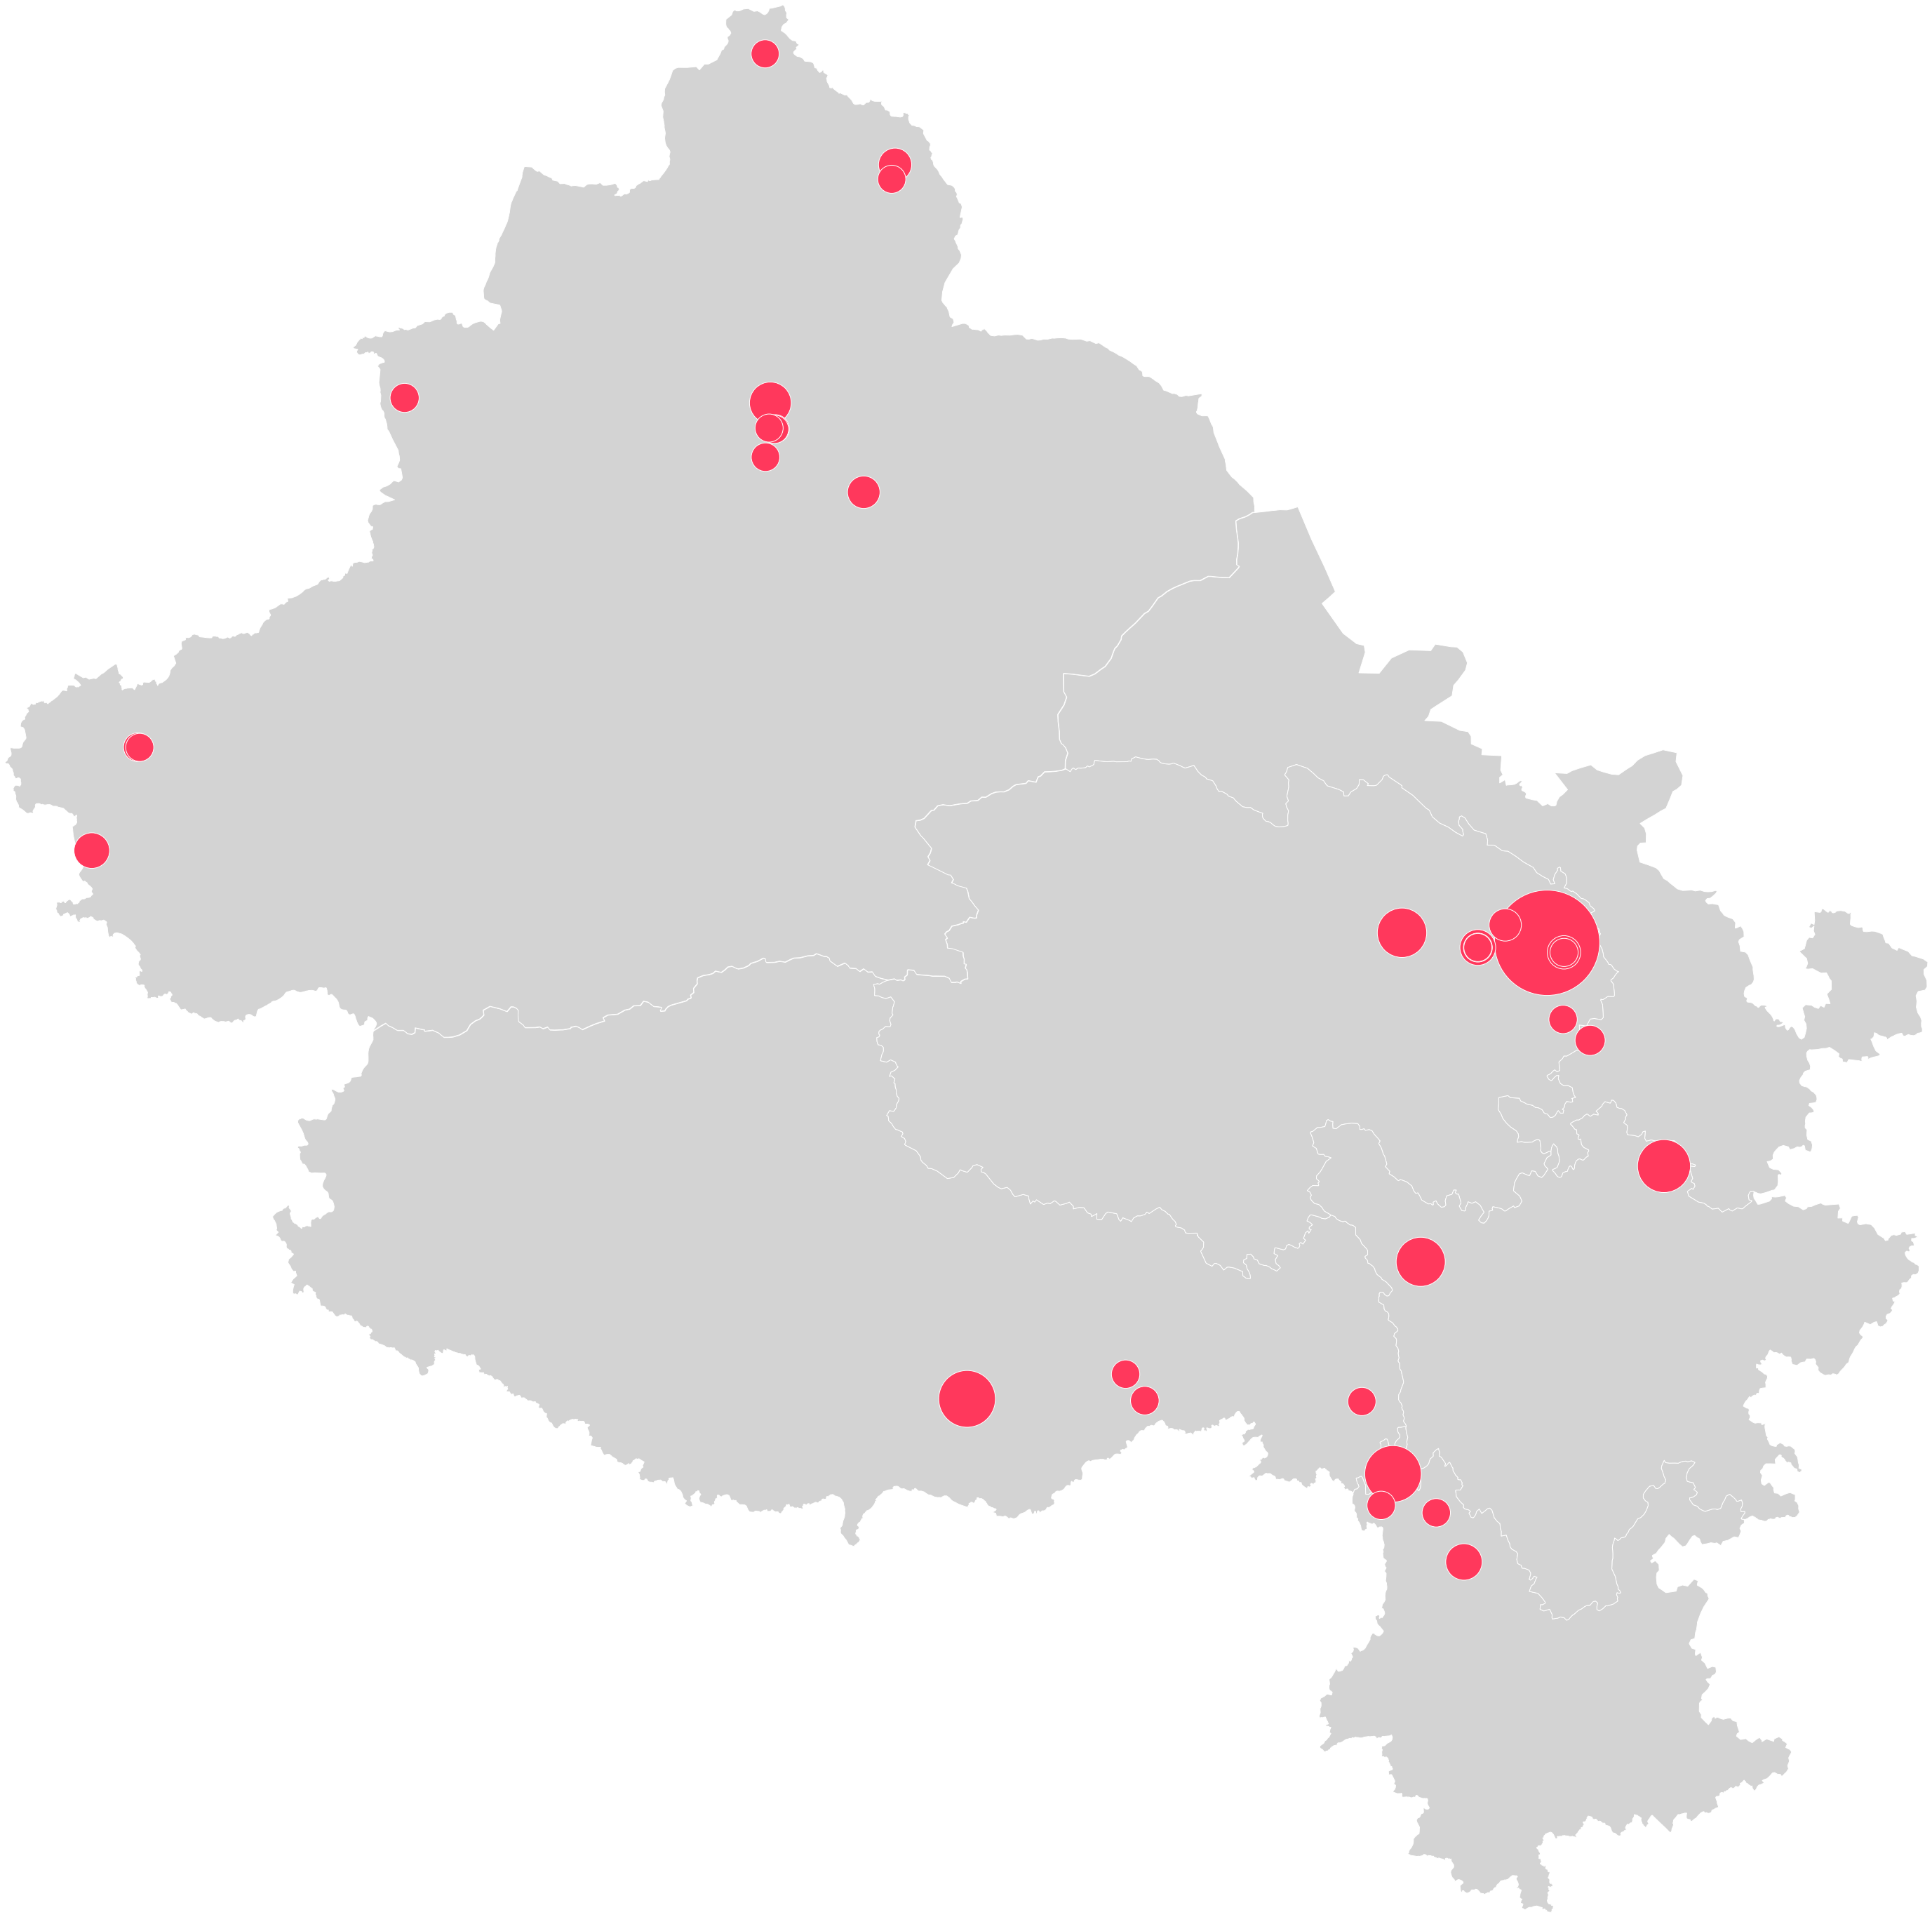

In [50]:
#maps the new data with larger dots indicating concentrations of listings
bounds=provinces.total_bounds
ax = gplt.polyplot(provinces,
                  gplt.crs.Mercator(),
                  figsize=(50,50),
                  edgecolor='white',
                  facecolor='lightgray')
pointplot_kwargs={'marker':'o', 'color':'#FF385C', 'edgecolor':'white'}
# The commented code places the markers at the bottom of the page, I can't work out why or how to fix it.
# for idx, row in middles.iterrows():
#     ax.text(float(row[1]), float(row[2]), s=row[0])
gplt.pointplot(listing_counts_by_city, 
                ax=ax,
                scale='counts',
                limits=(40, 150),
                extent=bounds,
                **pointplot_kwargs)
plt.savefig('scaled_locations.png')

The map shows a huge concentration of listings in Xining, Qinghai which has been the location of many human rights abuses against Tibetans.

There are also concentrations in Lhasa in TAR, Deqen in Yunnan, and Aba in Sichuan.   

### Looking at prices
The following section was designed to look at the prices of the rentals and how they compare to the cost of living and salaries of local people. However, there was only price information collected for the Xinjiang listings and salaries are hard to come by, especially segregated by ethnicity, so this no useful insights were gleaned.

In [ ]:
#cleans up the price column and converts it to numerical
listings_by_city['price'] = listings_by_city['price'].str.strip('$').str.replace(',','').astype(float)

In [61]:
#displays the columns
listings_by_city.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'address', 'bedLabel', 'city', 'photo',
       'price', 'roomType', 'stars', 'state', 'url', 'geometry', 'lat',
       'long'],
      dtype='object')

In [350]:
#shows the top of the price columns
listings_by_city['price'].head()

0    24.0
1    45.0
2    32.0
3    47.0
4    17.0
Name: price, dtype: float64

In [351]:
#finds the mean of the prices
listings_by_city['price'].mean()

157.29947916666666

In [67]:
#shows the mean of the prices (and other irrelevant numberical columns) sorted from most to least expensive
listings_by_city.groupby('address').mean().sort_values(by='price', ascending=False)

,Unnamed: 0,Unnamed: 0.1,price,stars,lat,long
address,,,,,,
"Wujiaqu, Xinjiang",91.000000,92.000000,929.000000,NaN,47.039090,89.757900
"Altay, Xinjiang",237.510638,238.510638,303.702128,4.800000,44.917397,86.547613
"Turpan, Xinjiang",242.884615,243.884615,274.730769,4.666667,43.823709,85.378468
"Karamay, Xinjiang",300.727273,301.727273,230.545455,4.812500,44.728538,85.377204
"Ili, Xinjiang",279.407407,280.407407,210.703704,4.961538,44.161458,87.244141
"Kashgar, Xinjiang",48.088608,48.645570,110.531646,4.920000,39.479581,76.215284
"Bayingol, Xinjiang",329.400000,330.400000,104.600000,5.000000,43.826412,84.927264
"Urumqi, Xinjiang",299.944056,300.944056,96.713287,4.806452,44.266769,86.741604
"Altay Prefecture, Xinjiang",312.666667,313.666667,86.666667,5.000000,43.668305,85.444570


### Conclusions

This analysis shows a staggering number of Airbnb listings spread across Tibet and East Turkestan, including many in the places where the Chinese government is committing regular attrocities against oppressed ethnicities. 

The scrape pulled a huge amount of data including descriptions and links to photos which may provide useful further insights for a Chinese speaker or someone looking for specific information in interior photographs.